In [1]:
import sys  
sys.path.insert(1, '/Users/asifahmed/Documents/Codes/MyRecourseProject')


from models.model_trainer import ModelTrainer
from evaluation.evaluator import Evaluator
from visualization.visualizer import Visualizer
from data_handling.crdit_data import Credit
from explainability.explainer_factory import get_explainer
import pandas as pd

In [9]:
credit_instance = Credit(target_column='NoDefaultNextMonth')
credit_instance.load_csv('/Users/asifahmed/Documents/Codes/MyRecourseProject/datasets/processed/credit_processed.csv')
credit_instance.select_features(['NoDefaultNextMonth', 'MostRecentBillAmount', 'MostRecentPaymentAmount'])
credit_instance.filter_non_zero(['MostRecentBillAmount', 'MostRecentPaymentAmount'])
credit_instance.balanced_sample(2000)
print(len(credit_instance.data))
credit_instance.remove_outliers()

CSV file loaded successfully with delimiter: ','
Selected features are now active: ['NoDefaultNextMonth', 'MostRecentBillAmount', 'MostRecentPaymentAmount']
Data filtered. Remaining rows: 23515.
4000
Removed 545 outliers. New dataset size: 3455


In [10]:
credit_instance.print_features_names()

Feature names in the dataset:
NoDefaultNextMonth
MostRecentBillAmount
MostRecentPaymentAmount


In [ ]:
credit_instance

In [11]:
credit_instance.merge_duplicates_assign_majority(exclude_columns='NoDefaultNextMonth')

Original data count: 3455, new data count after merging duplicates: 2048
Duplicates merged and majority value assigned based on the most common value of excluded columns.


In [4]:
print((credit_instance.data['NoDefaultNextMonth'] == 1).sum())

909


In [12]:
trainer = ModelTrainer()

data = trainer.normalize_columns(data=credit_instance.data, exclude_columns=['NoDefaultNextMonth'])

trainer.split_data(data, target_column='NoDefaultNextMonth')


model = trainer.train('svm')

evaluator = Evaluator(model, trainer.X_test, trainer.y_test)
evaluator.report()

Numerical columns normalized.
Data split into train and test sets.
svm model trained successfully.
Accuracy: 0.5804878048780487
Precision: 0.6216216216216216
Recall: 0.24210526315789474
F1 Score: 0.3484848484848485
Confusion Matrix:
 [[192  28]
 [144  46]]
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.87      0.69       220
           1       0.62      0.24      0.35       190

    accuracy                           0.58       410
   macro avg       0.60      0.56      0.52       410
weighted avg       0.59      0.58      0.53       410



In [36]:
print((trainer.y_train==1).sum())


594


/opt/anaconda3/envs/research/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


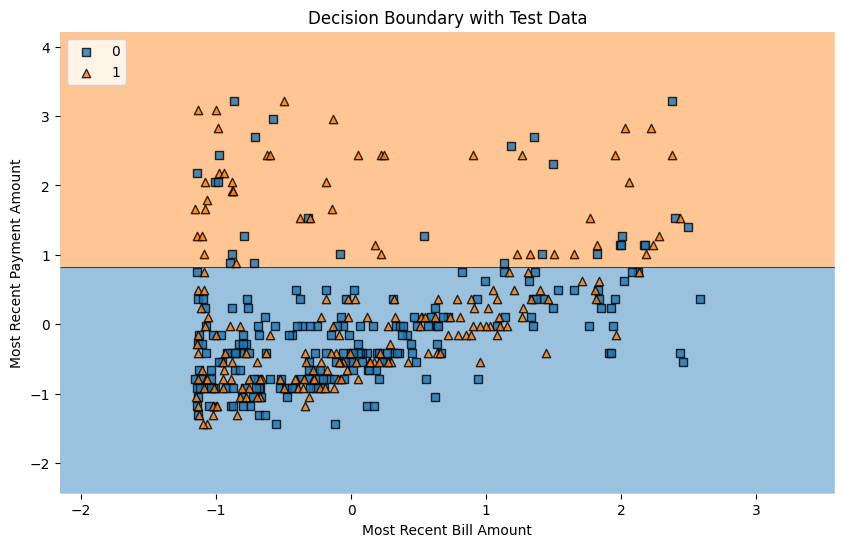

In [13]:
visualizer = Visualizer(model, trainer.X_test, trainer.y_test)
feature_names = ('Most Recent Bill Amount', 'Most Recent Payment Amount')
visualizer.plot_decision_boundary(feature_names)

# visualizer = Visualizer()
# visualizer.plot_decision_boundary(model, trainer.X_test, trainer.y_test, evaluator.find_misclassified_samples())

In [28]:
print(trainer.X_test)

       MaxPaymentAmountOverLast6Months  MostRecentPaymentAmount
2776                         -0.013420                 1.195723
5244                         -0.802830                 0.534980
29021                        -1.874171                -1.337126
6073                          1.339853                 1.966591
7058                          0.606830                -1.116878
...                                ...                      ...
5367                          2.072877                 1.746343
20116                        -0.069806                 0.534980
28560                        -0.126193                 2.076714
18719                        -0.802830                 0.975476
21440                         0.155739                -0.125763

[205 rows x 2 columns]


In [21]:
# continuous_features = ['Age', 'EducationLevel', 'MaxPaymentAmountOverLast6Months', 'MonthsWithZeroBalanceOverLast6Months', 'MonthsWithLowSpendingOverLast6Months', 'MonthsWithHighSpendingOverLast6Months', 'MostRecentBillAmount', 'MostRecentPaymentAmount', 'TotalOverdueCounts', 'TotalMonthsOverdue', 'HistoryOfOverduePayments']

continuous_features = ['Age']
print(continuous_features)
explainer = get_explainer('dice', model=model, data=credit_instance.data,
                          continuous_features=continuous_features,
                          outcome_name='NoDefaultNextMonth')
y_pred = model.predict(trainer.X_test)

# Step 2: Convert predictions to a Series for easy boolean indexing
y_pred_series = pd.Series(y_pred, index=trainer.X_test.index)

# Step 3: Filter the instances where predictions are 1
predicted_defaults = trainer.X_test[y_pred_series == 0]
# Now, select the first few instances for explanation. Adjust the number as needed.
query_instance = predicted_defaults.iloc[0:2]
counterfactuals = explainer.generate_explanation(query_instance, total_CFs=1)


['Age']


100%|██████████| 2/2 [00:00<00:00, 60.72it/s]

Query instance (original outcome : 0)


,Age,MostRecentPaymentAmount,NoDefaultNextMonth
0,66,150,0



Diverse Counterfactual set (new outcome: 1)


,Age,MostRecentPaymentAmount,NoDefaultNextMonth
0,-,1150,1


Query instance (original outcome : 0)


,Age,MostRecentPaymentAmount,NoDefaultNextMonth
0,57,60,0



Diverse Counterfactual set (new outcome: 1)


,Age,MostRecentPaymentAmount,NoDefaultNextMonth
0,38,2010,1
